In [421]:
from diffcam.util import LOGPATH, load_pickle, RECONSTRUCTIONPATH, DATAPATH
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.image as mpimg
import os
import cv2

In [422]:
def load_data(name):
    files = []
    files.extend(glob.glob(os.path.join(LOGPATH,name),recursive=True))

    pickles = []
    for f in files:
        pickles.append(load_pickle(f))
        
    return pickles

algo_pickle = load_data("lasso*.pkl")
all_pickle = load_data("*.pkl")

In [423]:
# Grab first level information

def get_data_from_dict(pickle):
    lambda_ = []
    algo = []
    delta = []
    mse = []
    psnr = []
    ssim = []
    lpips = []
    mse_mean = []
    psnr_mean = []
    ssim_mean = []
    lpips_mean = []
    n_iter = []
    images = ['img1_rgb', 'img3_rgb', 'img4_rgb', 'img5_rgb', 'img6_rgb', 'img7_rgb', 'img8_rgb']
    lenseless = []

    for save in pickle:
        algo.append(save['algo'])
        lambda_.append(save['lambda'])
        delta.append(save['delta'])
        mse.append(save['mse'])
        psnr.append(save['psnr'])
        ssim.append(save['ssim'])
        lpips.append(save['lpips'])
        mse_mean.append(sum(save['mse'])/len(save['mse']))
        psnr_mean.append(sum(save['psnr'])/len(save['psnr']))
        ssim_mean.append(sum(save['ssim'])/len(save['ssim']))
        lpips_mean.append(sum(save['lpips'])/len(save['lpips']))
        n_iter.append(save['n_iter'])

        fp = []
        for im in images:
            fp.append(save[im]['recon_fp'])
        lenseless.append(fp)
    return lambda_, algo, delta, mse, psnr, ssim, lpips, mse_mean, psnr_mean, ssim_mean, lpips_mean, n_iter, images, lenseless

In [424]:
lambda_, algo, delta, mse, psnr, ssim, lpips, mse_mean, psnr_mean, ssim_mean, lpips_mean, n_iter, images, lenseless = get_data_from_dict(algo_pickle)

In [425]:
def get_photo(path):
    end = os.path.split(path)[-1]
    path = os.path.join(RECONSTRUCTIONPATH, end)
    data = mpimg.imread(path)
    return data

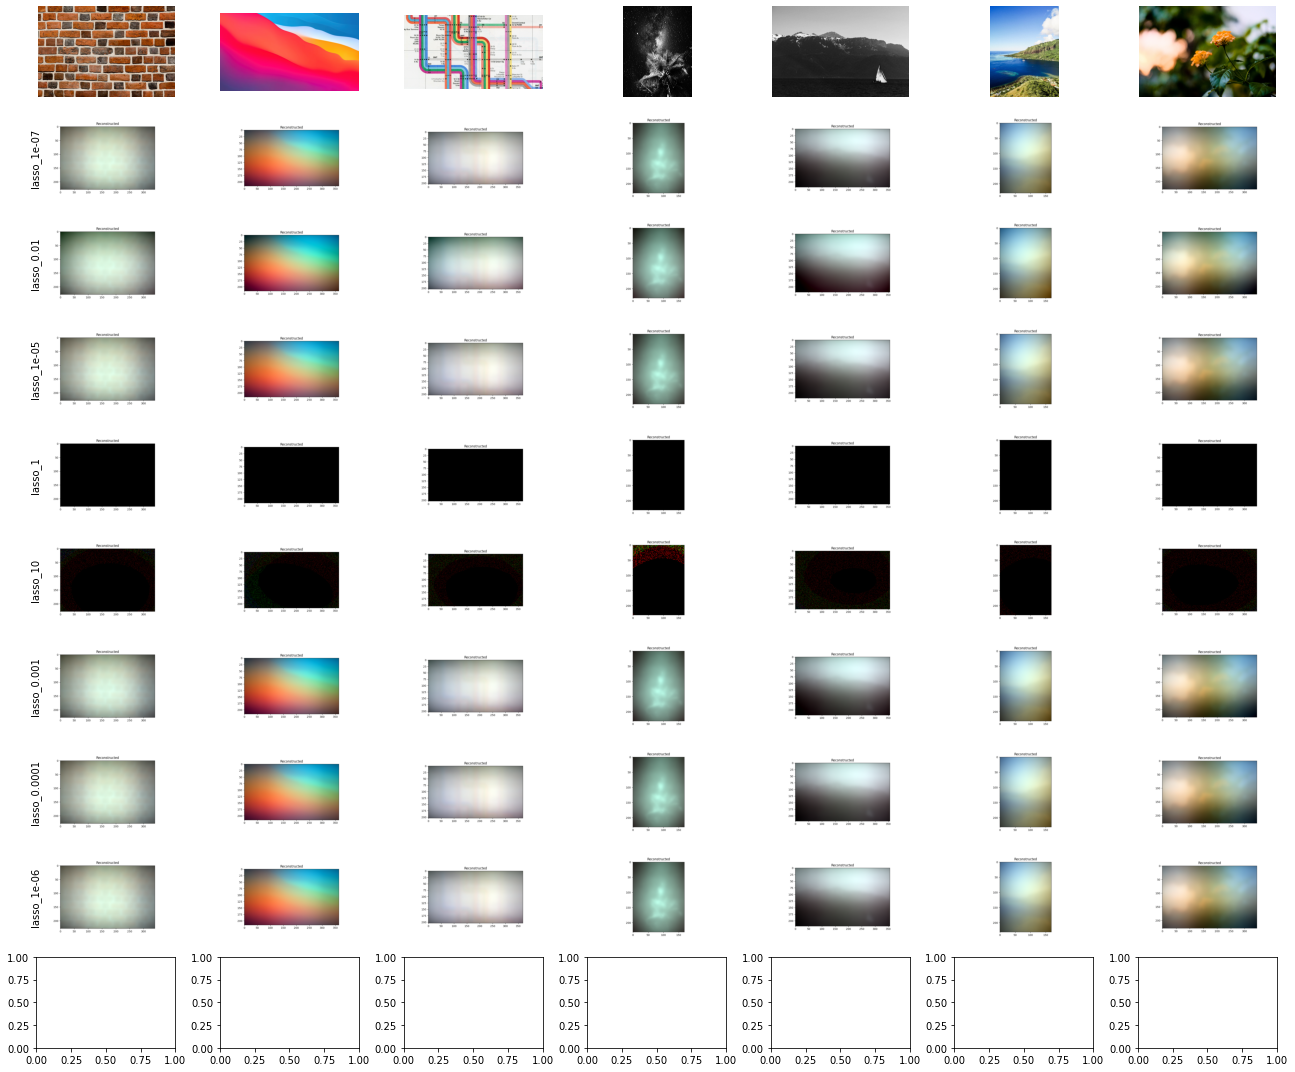

In [442]:
gt = []
for i in range(1,9):
    gt.append(os.path.join(DATAPATH,'our_images','lensed',f'img{i}_original.png'))

run = len(lenseless)
fig, ax = plt.subplots(run+1, 7, figsize=(18,15))
ax[0,0].imshow(cv2.cvtColor(cv2.imread(gt[0]), cv2.COLOR_BGR2RGB))
ax[0,1].imshow(cv2.cvtColor(cv2.imread(gt[2]), cv2.COLOR_BGR2RGB))
ax[0,2].imshow(cv2.cvtColor(cv2.imread(gt[3]), cv2.COLOR_BGR2RGB))
ax[0,3].imshow(cv2.cvtColor(cv2.imread(gt[4]), cv2.COLOR_BGR2RGB))
ax[0,4].imshow(cv2.cvtColor(cv2.imread(gt[5]), cv2.COLOR_BGR2RGB))
ax[0,5].imshow(cv2.cvtColor(cv2.imread(gt[6]), cv2.COLOR_BGR2RGB))
ax[0,6].imshow(cv2.cvtColor(cv2.imread(gt[7]), cv2.COLOR_BGR2RGB))
for i in range(1,run+1):
    for j in range(len(lenseless[i])):
        ax[i,j].imshow(get_photo(lenseless[i][j]))
        ax[i, 0].set_ylabel(f"{algo[i]}_{lambda_[i]}")

for i in range(0,run+1):
    for j in range(len(lenseless[i])):      
        ax[i, j].xaxis.set_visible(False)
        plt.setp(ax[i, j].spines.values(), visible=False)
        ax[i, j].tick_params(left=False, labelleft=False)
        ax[i, j].patch.set_visible(False)
        plt.tight_layout()
plt.show()

In [306]:
lambda_, algo, delta, mse, psnr, ssim, lpips, mse_mean, psnr_mean, ssim_mean, lpips_mean, n_iter, images, lenseless = get_data_from_dict(all_pickle)

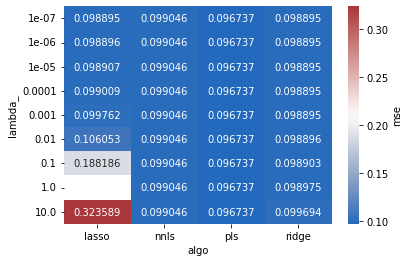

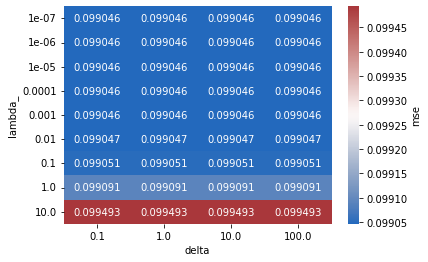

In [389]:
def heatmap(metric, algo, lambda_, delta, metric_name):
    a = {metric_name:metric, "algo": algo, "lambda_":lambda_, "delta":delta, "n_iter":n_iter}
    df = pd.DataFrame(a)

    df_huber = df[(df['algo']=='pls_huber') & (df['n_iter'] == 100)]
    df = df[df['algo']!='pls_huber']

    df = df.pivot(index='lambda_', columns="algo", values=metric_name)

    sns.heatmap(df, annot=True, fmt="f", cbar_kws={'label': metric_name}, cmap="vlag")
    plt.show()
    df_huber = df_huber.pivot("lambda_","delta",metric_name)
    sns.heatmap(df_huber, annot=True, fmt="f", cbar_kws={'label': metric_name}, cmap="vlag")
    plt.show()
    
heatmap(mse_mean, algo, lambda_, delta, "mse")

In [358]:
algo_lambda = [i +"_"+ str(j) for i, j in zip(algo, lambda_)]
image_order = [['img8_rgb', 'img1_rgb', 'img3_rgb', 'img6_rgb', 'img7_rgb','img5_rgb','img4_rgb']]*len(mse)

In [359]:
a = {'mse':mse, "algo_lambda":algo_lambda, "n_iter":n_iter, "image_order": image_order}
df = pd.DataFrame(a)

df = df[~(df['algo_lambda'].str.contains('pls_huber'))]
df = df.explode(['mse', 'image_order'])

df = df.pivot('algo_lambda', "image_order", "mse").reset_index(drop=False)

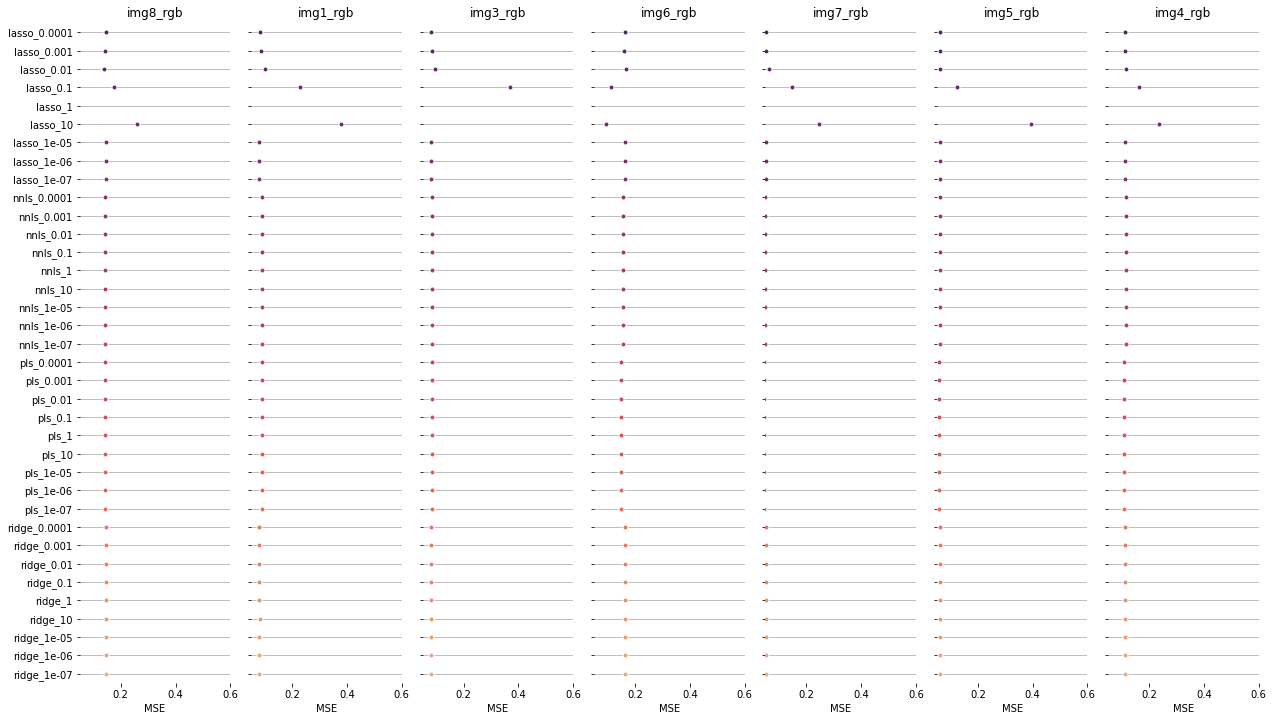

In [386]:
g = sns.PairGrid(df,
                 x_vars=df.columns[1:], y_vars=['algo_lambda'],
                 height=10, aspect=.25)
g.map(sns.stripplot, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(.05, .6), xlabel="MSE", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['img8_rgb', 'img1_rgb', 'img3_rgb', 'img6_rgb', 'img7_rgb','img5_rgb','img4_rgb']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [383]:
df.iloc[:,1:].values

array([[0.14451597027833668, 0.08073470697158623, 0.08020958133087465,
        0.16257819846792448, 0.052101225484703084, 0.06251965835920806,
        0.1104047863683045],
       [0.14161412094701356, 0.08558476029981682, 0.08494855822400503,
        0.16071664411963976, 0.05094143036495199, 0.061505495086401324,
        0.1130230546821736],
       [0.14020301986661438, 0.10076710734829947, 0.0969025927419649,
        0.16533954998198452, 0.0615255533372188, 0.06129688579297163,
        0.11633691323538364],
       [0.17514233768923765, 0.22850136626156678, 0.36886624632871723,
        0.11280159507423992, 0.1473967278463777, 0.12275143009589133,
        0.16184229346615484],
       [nan, nan, nan, nan, nan, nan, nan],
       [0.2601102915314421, 0.3779811742988412, 0.6578528876130519,
        0.094226201857311, 0.24413030360994933, 0.3942291500215411,
        0.2365910929496212],
       [0.14477107767369798, 0.08027590745633792, 0.07979950017829271,
        0.162608542379711, 0.052199